In [1]:
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

In [2]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [3]:
tf.__version__

'2.11.0'

## Load data

In [4]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):

    nfeatures = 10
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [5]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
                interact_arch=[40] * 2, subnet_arch=[40] * 2,
                batch_size=1000, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.09301, val loss: 0.08815
Main effects training epoch: 2, train loss: 0.04229, val loss: 0.03871
Main effects training epoch: 3, train loss: 0.01927, val loss: 0.01697
Main effects training epoch: 4, train loss: 0.02198, val loss: 0.02066
Main effects training epoch: 5, train loss: 0.02164, val loss: 0.02035
Main effects training epoch: 6, train loss: 0.01769, val loss: 0.01597
Main effects training epoch: 7, train loss: 0.01721, val loss: 0.01518
Main effects training epoch: 8, train loss: 0.01716, val loss: 0.01509
Main effects training epoch: 9, train loss: 0.01650, val loss: 0.01456
Main effects training epoch: 10, train loss: 0.01608, val loss: 0.01430
Main effects training epoch: 11, train loss: 0.01593, val loss: 0.01424
Main effects training epoch: 12, train loss: 0.01564, val loss: 0.01394
Main effects training e

Main effects training epoch: 118, train loss: 0.01081, val loss: 0.00997
Main effects training epoch: 119, train loss: 0.01088, val loss: 0.01004
Main effects training epoch: 120, train loss: 0.01081, val loss: 0.00997
Main effects training epoch: 121, train loss: 0.01076, val loss: 0.00993
Main effects training epoch: 122, train loss: 0.01072, val loss: 0.00990
Main effects training epoch: 123, train loss: 0.01071, val loss: 0.00990
Main effects training epoch: 124, train loss: 0.01073, val loss: 0.00992
Main effects training epoch: 125, train loss: 0.01069, val loss: 0.00989
Main effects training epoch: 126, train loss: 0.01068, val loss: 0.00988
Main effects training epoch: 127, train loss: 0.01068, val loss: 0.00987
Main effects training epoch: 128, train loss: 0.01067, val loss: 0.00987
Main effects training epoch: 129, train loss: 0.01066, val loss: 0.00986
Main effects training epoch: 130, train loss: 0.01068, val loss: 0.00989
Main effects training epoch: 131, train loss: 0.010

Interaction training epoch: 7, train loss: 0.00807, val loss: 0.00767
Interaction training epoch: 8, train loss: 0.00777, val loss: 0.00739
Interaction training epoch: 9, train loss: 0.00746, val loss: 0.00710
Interaction training epoch: 10, train loss: 0.00718, val loss: 0.00684
Interaction training epoch: 11, train loss: 0.00694, val loss: 0.00661
Interaction training epoch: 12, train loss: 0.00672, val loss: 0.00645
Interaction training epoch: 13, train loss: 0.00649, val loss: 0.00621
Interaction training epoch: 14, train loss: 0.00631, val loss: 0.00608
Interaction training epoch: 15, train loss: 0.00618, val loss: 0.00598
Interaction training epoch: 16, train loss: 0.00604, val loss: 0.00583
Interaction training epoch: 17, train loss: 0.00594, val loss: 0.00572
Interaction training epoch: 18, train loss: 0.00584, val loss: 0.00568
Interaction training epoch: 19, train loss: 0.00577, val loss: 0.00565
Interaction training epoch: 20, train loss: 0.00577, val loss: 0.00555
Interacti

Interaction training epoch: 124, train loss: 0.00354, val loss: 0.00366
Interaction training epoch: 125, train loss: 0.00363, val loss: 0.00375
Interaction training epoch: 126, train loss: 0.00351, val loss: 0.00360
Interaction training epoch: 127, train loss: 0.00348, val loss: 0.00358
Interaction training epoch: 128, train loss: 0.00345, val loss: 0.00355
Interaction training epoch: 129, train loss: 0.00342, val loss: 0.00352
Interaction training epoch: 130, train loss: 0.00341, val loss: 0.00353
Interaction training epoch: 131, train loss: 0.00347, val loss: 0.00357
Interaction training epoch: 132, train loss: 0.00339, val loss: 0.00350
Interaction training epoch: 133, train loss: 0.00345, val loss: 0.00355
Interaction training epoch: 134, train loss: 0.00337, val loss: 0.00347
Interaction training epoch: 135, train loss: 0.00332, val loss: 0.00347
Interaction training epoch: 136, train loss: 0.00338, val loss: 0.00346
Interaction training epoch: 137, train loss: 0.00335, val loss: 

Interaction training epoch: 238, train loss: 0.00230, val loss: 0.00240
Interaction training epoch: 239, train loss: 0.00230, val loss: 0.00239
Interaction training epoch: 240, train loss: 0.00232, val loss: 0.00241
Interaction training epoch: 241, train loss: 0.00223, val loss: 0.00232
Interaction training epoch: 242, train loss: 0.00222, val loss: 0.00232
Interaction training epoch: 243, train loss: 0.00224, val loss: 0.00234
Interaction training epoch: 244, train loss: 0.00232, val loss: 0.00239
Interaction training epoch: 245, train loss: 0.00224, val loss: 0.00232
Interaction training epoch: 246, train loss: 0.00224, val loss: 0.00231
Interaction training epoch: 247, train loss: 0.00220, val loss: 0.00230
Interaction training epoch: 248, train loss: 0.00222, val loss: 0.00231
Interaction training epoch: 249, train loss: 0.00220, val loss: 0.00231
Interaction training epoch: 250, train loss: 0.00225, val loss: 0.00234
Interaction training epoch: 251, train loss: 0.00225, val loss: 

Interaction training epoch: 352, train loss: 0.00200, val loss: 0.00210
Interaction training epoch: 353, train loss: 0.00201, val loss: 0.00212
Interaction training epoch: 354, train loss: 0.00199, val loss: 0.00211
Interaction training epoch: 355, train loss: 0.00199, val loss: 0.00211
Interaction training epoch: 356, train loss: 0.00198, val loss: 0.00209
Interaction training epoch: 357, train loss: 0.00200, val loss: 0.00212
Interaction training epoch: 358, train loss: 0.00207, val loss: 0.00217
Interaction training epoch: 359, train loss: 0.00215, val loss: 0.00230
Interaction training epoch: 360, train loss: 0.00201, val loss: 0.00211
Interaction training epoch: 361, train loss: 0.00203, val loss: 0.00214
Interaction training epoch: 362, train loss: 0.00206, val loss: 0.00218
Interaction training epoch: 363, train loss: 0.00199, val loss: 0.00211
Interaction training epoch: 364, train loss: 0.00198, val loss: 0.00209
Interaction training epoch: 365, train loss: 0.00197, val loss: 

Interaction training epoch: 468, train loss: 0.00196, val loss: 0.00217
Interaction training epoch: 469, train loss: 0.00199, val loss: 0.00211
Interaction training epoch: 470, train loss: 0.00193, val loss: 0.00212
Interaction training epoch: 471, train loss: 0.00187, val loss: 0.00207
Interaction training epoch: 472, train loss: 0.00195, val loss: 0.00210
Interaction training epoch: 473, train loss: 0.00187, val loss: 0.00206
Interaction training epoch: 474, train loss: 0.00191, val loss: 0.00208
Interaction training epoch: 475, train loss: 0.00187, val loss: 0.00205
Interaction training epoch: 476, train loss: 0.00187, val loss: 0.00204
Interaction training epoch: 477, train loss: 0.00189, val loss: 0.00205
Interaction training epoch: 478, train loss: 0.00191, val loss: 0.00208
Interaction training epoch: 479, train loss: 0.00204, val loss: 0.00227
Interaction training epoch: 480, train loss: 0.00194, val loss: 0.00210
Interaction training epoch: 481, train loss: 0.00186, val loss: 

Fine tuning epoch: 97, train loss: 0.00189, val loss: 0.00198
Fine tuning epoch: 98, train loss: 0.00192, val loss: 0.00198
Fine tuning epoch: 99, train loss: 0.00190, val loss: 0.00199
Fine tuning epoch: 100, train loss: 0.00193, val loss: 0.00203
Fine tuning epoch: 101, train loss: 0.00193, val loss: 0.00201
Fine tuning epoch: 102, train loss: 0.00198, val loss: 0.00207
Fine tuning epoch: 103, train loss: 0.00192, val loss: 0.00197
Fine tuning epoch: 104, train loss: 0.00224, val loss: 0.00233
Fine tuning epoch: 105, train loss: 0.00199, val loss: 0.00205
Fine tuning epoch: 106, train loss: 0.00195, val loss: 0.00204
Fine tuning epoch: 107, train loss: 0.00207, val loss: 0.00218
Fine tuning epoch: 108, train loss: 0.00192, val loss: 0.00199
Fine tuning epoch: 109, train loss: 0.00198, val loss: 0.00208
Fine tuning epoch: 110, train loss: 0.00189, val loss: 0.00199
Fine tuning epoch: 111, train loss: 0.00189, val loss: 0.00197
Fine tuning epoch: 112, train loss: 0.00194, val loss: 0.0

## Visualization

In [6]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

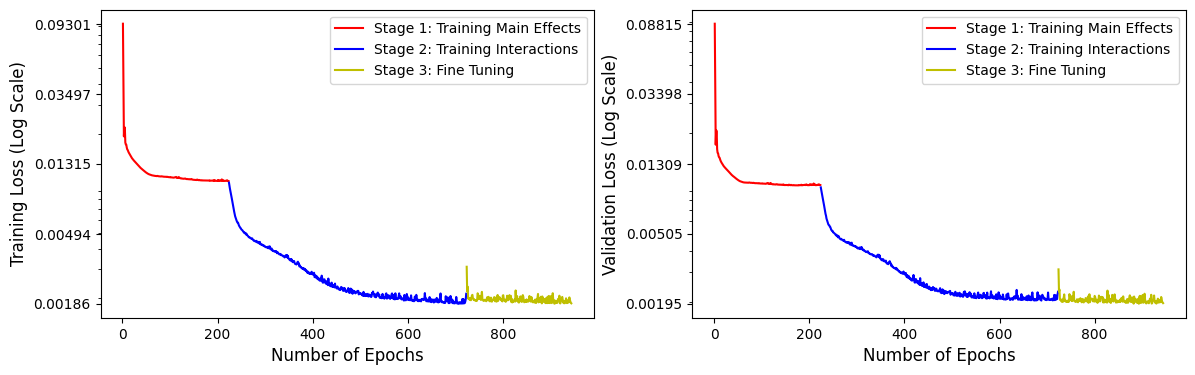

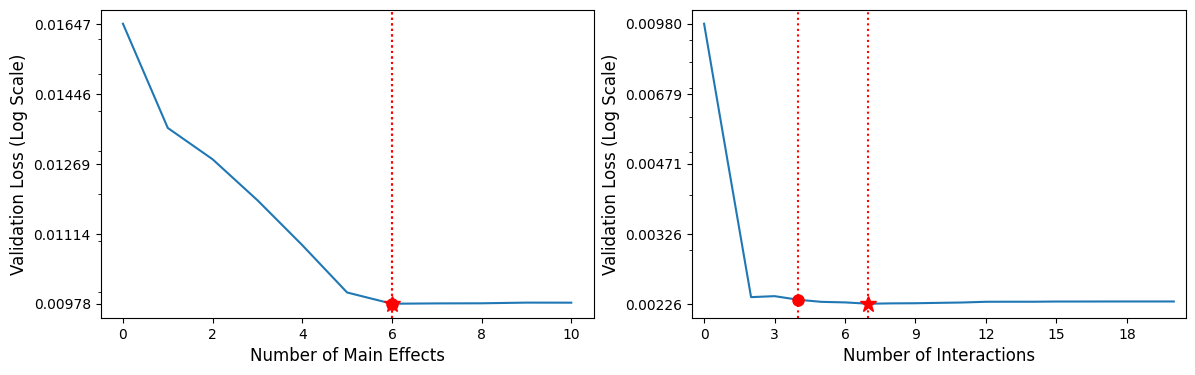

In [7]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

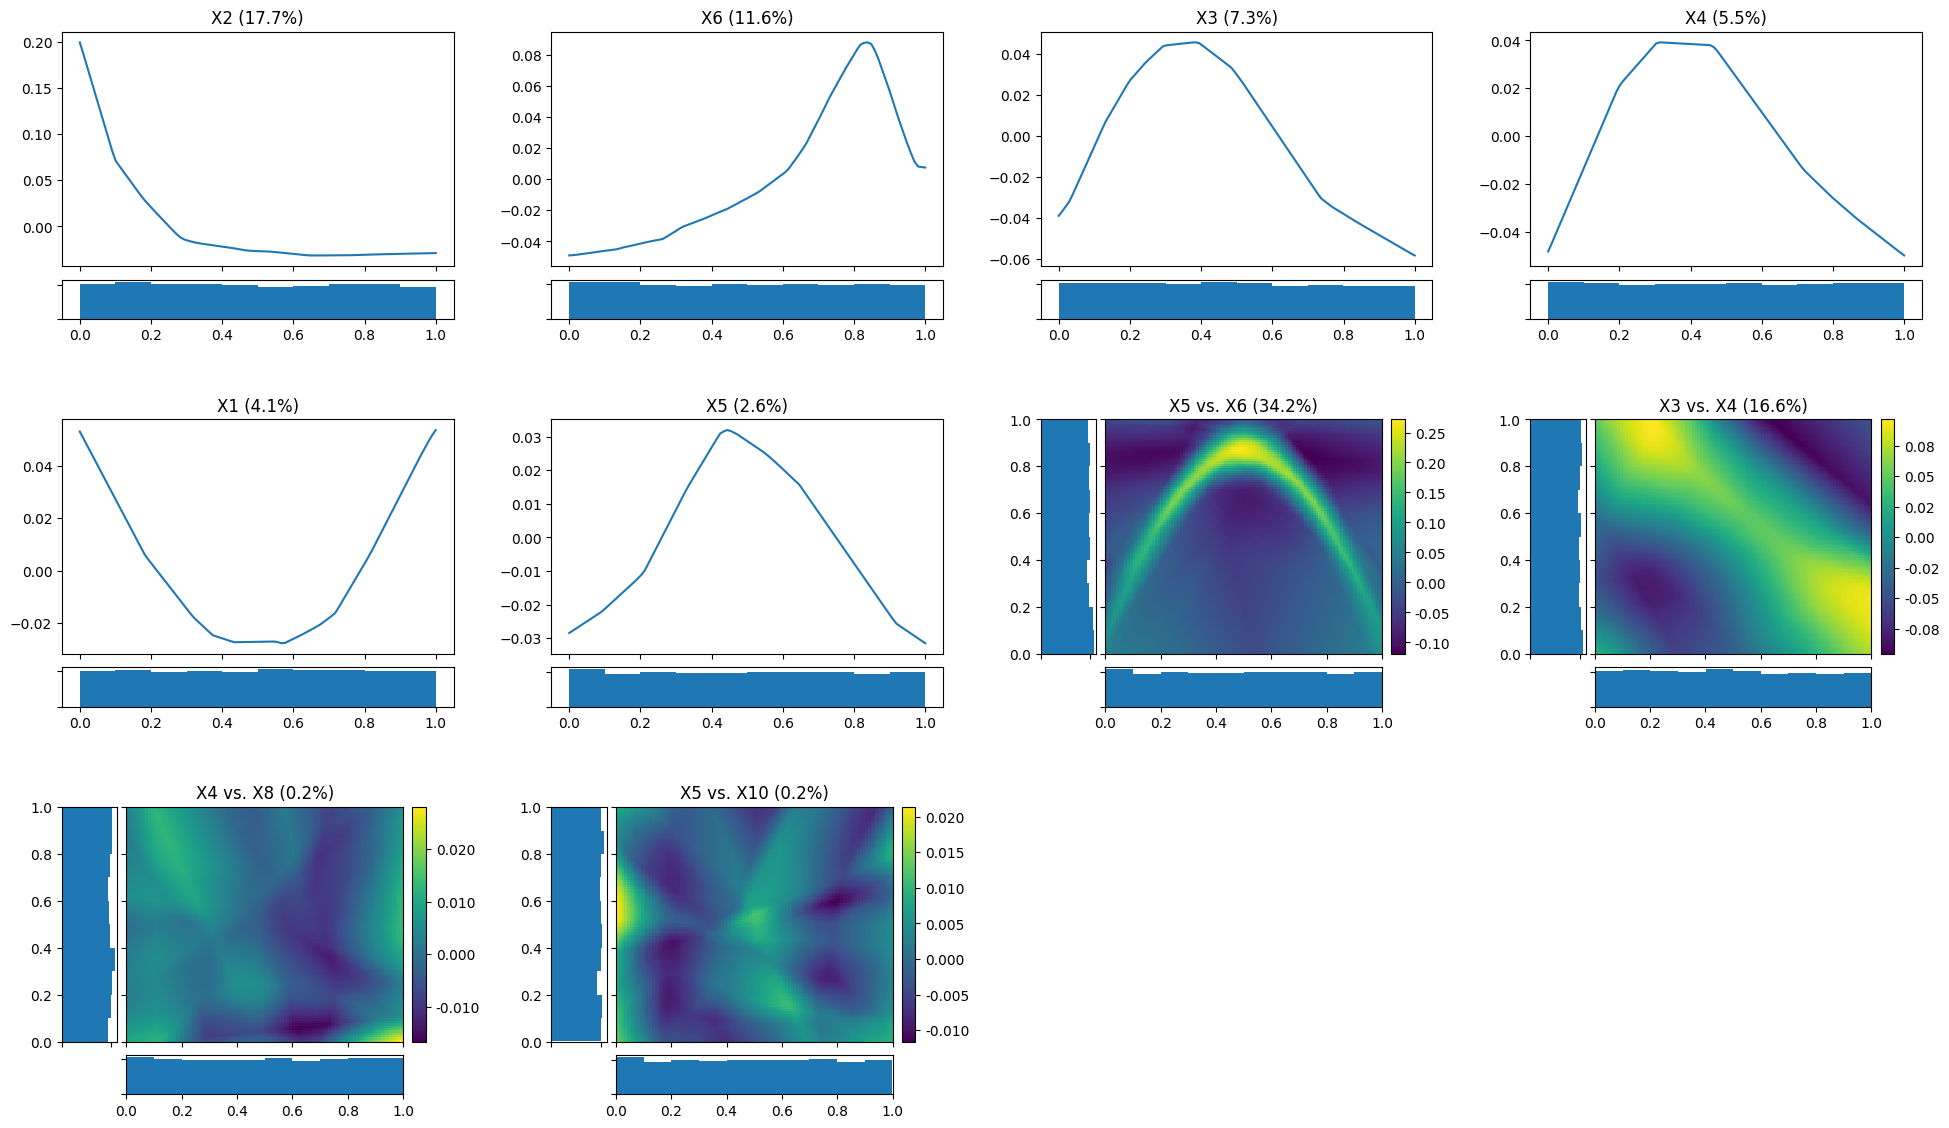

In [8]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

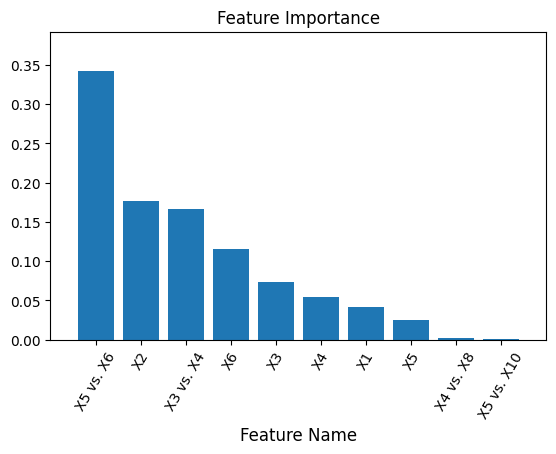

In [9]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [10]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

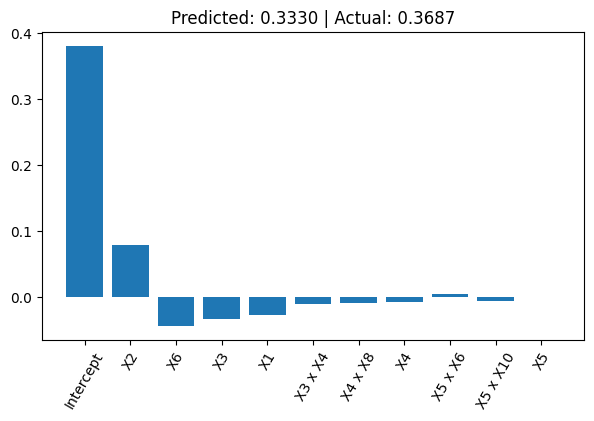

In [11]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

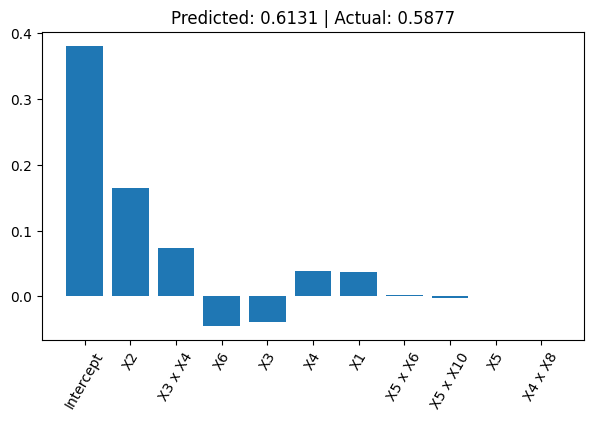

In [12]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [13]:
model.save(folder="./", name="model_saved")

In [14]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

# Shape constraints

In [15]:
model_debug = GAMINet(meta_info=meta_info, interact_num=0, 
                interact_arch=[40] * 2, subnet_arch=[40] * 2, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.001, 0.001, 0.001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                convex_list=[0, 1], mono_decreasing_list=[1], lattice_size=2, calibration_size=10,
                include_interaction_list=[(2, 3), (4, 5)],
                # manually inputted interactions are included in addition to prescreening interactions defined by interact_num.
                ## Model with Convexity Constraints are generally hard to train, try larger learning rates.
                verbose=True, val_ratio=0.2, random_state=random_state)
model_debug.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########


Main effects training epoch: 1, train loss: 0.01989, val loss: 0.01841
Main effects training epoch: 2, train loss: 0.01833, val loss: 0.01687
Main effects training epoch: 3, train loss: 0.01764, val loss: 0.01615
Main effects training epoch: 4, train loss: 0.01699, val loss: 0.01549
Main effects training epoch: 5, train loss: 0.01650, val loss: 0.01524
Main effects training epoch: 6, train loss: 0.01588, val loss: 0.01458
Main effects training epoch: 7, train loss: 0.01548, val loss: 0.01430
Main effects training epoch: 8, train loss: 0.01495, val loss: 0.01383
Main effects training epoch: 9, train loss: 0.01476, val loss: 0.01376
Main effects training epoch: 10, train loss: 0.01466, val loss: 0.01367
Main effects training epoch: 11, train loss: 0.01448, val loss: 0.01347
Main effects training epoch: 12, train loss: 0.01425, val loss: 0.01335
Main effects training epoch: 13, train loss: 0.01428, val loss: 0.01331
Main effects training epoch: 14, train loss: 0.01385, val loss: 0.01294
M

Main effects training epoch: 115, train loss: 0.01075, val loss: 0.01045
Main effects training epoch: 116, train loss: 0.01074, val loss: 0.01034
Main effects training epoch: 117, train loss: 0.01090, val loss: 0.01055
Main effects training epoch: 118, train loss: 0.01085, val loss: 0.01050
Main effects training epoch: 119, train loss: 0.01085, val loss: 0.01055
Main effects training epoch: 120, train loss: 0.01073, val loss: 0.01038
Main effects training epoch: 121, train loss: 0.01081, val loss: 0.01046
Main effects training epoch: 122, train loss: 0.01079, val loss: 0.01043
Main effects training epoch: 123, train loss: 0.01081, val loss: 0.01046
Main effects training epoch: 124, train loss: 0.01077, val loss: 0.01037
Main effects training epoch: 125, train loss: 0.01077, val loss: 0.01046
Main effects training epoch: 126, train loss: 0.01076, val loss: 0.01037
Main effects training epoch: 127, train loss: 0.01092, val loss: 0.01054
Main effects training epoch: 128, train loss: 0.010

Main effects training epoch: 228, train loss: 0.01069, val loss: 0.01032
Main effects training epoch: 229, train loss: 0.01069, val loss: 0.01033
Main effects training epoch: 230, train loss: 0.01087, val loss: 0.01053
Main effects training epoch: 231, train loss: 0.01069, val loss: 0.01032
Main effects training epoch: 232, train loss: 0.01064, val loss: 0.01028
Main effects training epoch: 233, train loss: 0.01063, val loss: 0.01027
Main effects training epoch: 234, train loss: 0.01070, val loss: 0.01035
Main effects training epoch: 235, train loss: 0.01063, val loss: 0.01020
Main effects training epoch: 236, train loss: 0.01061, val loss: 0.01024
Main effects training epoch: 237, train loss: 0.01071, val loss: 0.01035
Main effects training epoch: 238, train loss: 0.01066, val loss: 0.01029
Main effects training epoch: 239, train loss: 0.01071, val loss: 0.01032
Main effects training epoch: 240, train loss: 0.01062, val loss: 0.01026
Main effects training epoch: 241, train loss: 0.010

Main effects training epoch: 341, train loss: 0.01052, val loss: 0.01011
Main effects training epoch: 342, train loss: 0.01050, val loss: 0.01009
Main effects training epoch: 343, train loss: 0.01056, val loss: 0.01016
Main effects training epoch: 344, train loss: 0.01050, val loss: 0.01007
Main effects training epoch: 345, train loss: 0.01064, val loss: 0.01025
Main effects training epoch: 346, train loss: 0.01050, val loss: 0.01007
Main effects training epoch: 347, train loss: 0.01053, val loss: 0.01014
Main effects training epoch: 348, train loss: 0.01050, val loss: 0.01008
Main effects training epoch: 349, train loss: 0.01052, val loss: 0.01011
Main effects training epoch: 350, train loss: 0.01049, val loss: 0.01005
Main effects training epoch: 351, train loss: 0.01066, val loss: 0.01023
Main effects training epoch: 352, train loss: 0.01052, val loss: 0.01012
Main effects training epoch: 353, train loss: 0.01050, val loss: 0.01011
Main effects training epoch: 354, train loss: 0.010

##########Stage 1: main effect training stop.##########
##########Stage 2: interaction training start.##########
Interaction training epoch: 1, train loss: 0.00770, val loss: 0.00721
Interaction training epoch: 2, train loss: 0.00675, val loss: 0.00630
Interaction training epoch: 3, train loss: 0.00633, val loss: 0.00594
Interaction training epoch: 4, train loss: 0.00594, val loss: 0.00559
Interaction training epoch: 5, train loss: 0.00567, val loss: 0.00538
Interaction training epoch: 6, train loss: 0.00545, val loss: 0.00517
Interaction training epoch: 7, train loss: 0.00532, val loss: 0.00516
Interaction training epoch: 8, train loss: 0.00510, val loss: 0.00490
Interaction training epoch: 9, train loss: 0.00519, val loss: 0.00502
Interaction training epoch: 10, train loss: 0.00496, val loss: 0.00479
Interaction training epoch: 11, train loss: 0.00480, val loss: 0.00463
Interaction training epoch: 12, train loss: 0.00471, val loss: 0.00458
Interaction training epoch: 13, train loss: 

Interaction training epoch: 115, train loss: 0.00217, val loss: 0.00216
Interaction training epoch: 116, train loss: 0.00200, val loss: 0.00197
Interaction training epoch: 117, train loss: 0.00214, val loss: 0.00206
Interaction training epoch: 118, train loss: 0.00217, val loss: 0.00217
Interaction training epoch: 119, train loss: 0.00219, val loss: 0.00218
Interaction training epoch: 120, train loss: 0.00215, val loss: 0.00212
Interaction training epoch: 121, train loss: 0.00215, val loss: 0.00214
Interaction training epoch: 122, train loss: 0.00206, val loss: 0.00206
Interaction training epoch: 123, train loss: 0.00211, val loss: 0.00208
Interaction training epoch: 124, train loss: 0.00203, val loss: 0.00202
Interaction training epoch: 125, train loss: 0.00206, val loss: 0.00201
Interaction training epoch: 126, train loss: 0.00205, val loss: 0.00204
Interaction training epoch: 127, train loss: 0.00211, val loss: 0.00211
Interaction training epoch: 128, train loss: 0.00206, val loss: 

Fine tuning epoch: 70, train loss: 0.00193, val loss: 0.00194
Fine tuning epoch: 71, train loss: 0.00191, val loss: 0.00191
Fine tuning epoch: 72, train loss: 0.00205, val loss: 0.00200
Fine tuning epoch: 73, train loss: 0.00189, val loss: 0.00191
Fine tuning epoch: 74, train loss: 0.00204, val loss: 0.00207
Fine tuning epoch: 75, train loss: 0.00198, val loss: 0.00204
Fine tuning epoch: 76, train loss: 0.00201, val loss: 0.00204
Fine tuning epoch: 77, train loss: 0.00196, val loss: 0.00195
Fine tuning epoch: 78, train loss: 0.00191, val loss: 0.00194
Fine tuning epoch: 79, train loss: 0.00193, val loss: 0.00198
Fine tuning epoch: 80, train loss: 0.00195, val loss: 0.00197
Fine tuning epoch: 81, train loss: 0.00201, val loss: 0.00209
Fine tuning epoch: 82, train loss: 0.00207, val loss: 0.00209
Fine tuning epoch: 83, train loss: 0.00208, val loss: 0.00208
Fine tuning epoch: 84, train loss: 0.00200, val loss: 0.00201
Fine tuning epoch: 85, train loss: 0.00195, val loss: 0.00199
Fine tun

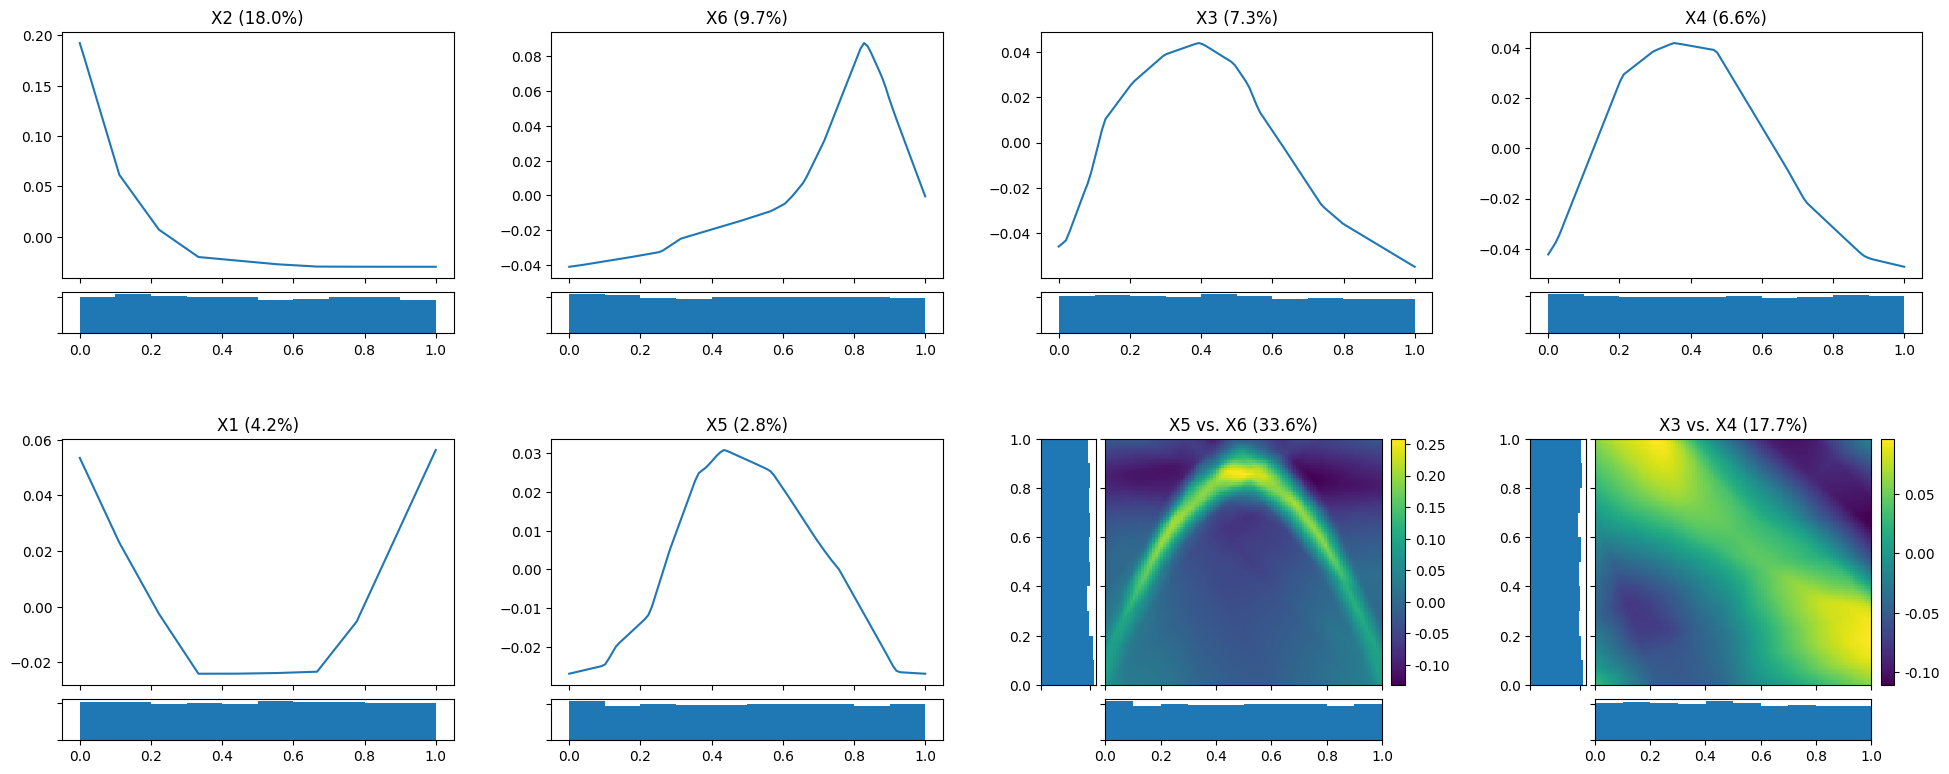

In [16]:
# The interactions are also constrained to be convex or concave, which is very different from the ground truth.
# (Decreased Predictive Performance)

data_dict_global = model_debug.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=False)